In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
#  Copyright 2024 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Franck Vidal (UKRI-STFC)

# CT scan acquisition simulation using [gVXR](https://gvirtualxray.sourceforge.io/) and CT reconstruction with [CIL](https://ccpi.ac.uk/cil/)

This example makes use of two open source libraries fro X-ray imaging. The first one is [gVXR](https://gvirtualxray.sourceforge.io/). It is used to simulate realistic radiographic images from a CAD model. The second one is [CIL](https://ccpi.ac.uk/cil/). It implements many CT reconstruction algorithms, including the well-known FDK. The details of the CT scan acquisition are given in the table below. Both FDK and SIRT (iterative method) reconstructions were performed. 

![Image comparison of the FDK and SIRT reconstructions](../results/dragon/comparison.png)

| Parameter | Value |
|-----------|-------|
| source-to-object distance (SOD) | 150 cm |
| object-to-detector distance (ODD) | 40 cm |
| source-to-detector distance (SDD) | 190 cm |
| detector resolution | 512 &times; 512 pixels |
| pixel pitch | 500 &times; 500 &mu;m |
| scintillator | 500 &mu;m of CsI|
| energy response of the detector | ![Plot of the energy response of the detector](../results/dragon/detector-energy_response.png) |
| detector impulse response | ![Plot of the detector impulse response](../results/dragon/detector-LSF.png) |
| tube anode material | tungsten |
| tube anode angle | 10&deg; |
| tube voltage | 160 kV |
| beam filtration | 1mm of Sn |
| tube exposure | 0.5 mAs |
| beam spectrum | ![Plot of the beam spectrum](../results/dragon/beam-spectrum.png) |
| sample geometry | ![](../results/dragon/wireframe.png) |
| sample material composition | Ti90Al6V4 |
| sample material density | 4.43 g/cm<sup>3</sup>|
| number of projection | 200 |
| first angle | 0&deg; |
| last angle | 360&deg; |
| number of flat images | 60 |

In [2]:
# Import packages
import os, time
import numpy as np

# Increase the font size in plots
import matplotlib
font = {'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt # Plotting

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3.utils import loadSpectrumSpekpy
from gvxrPython3 import gvxr2json # Simulate X-ray images
from gvxrPython3.utils import visualise # 3D visualisation in a Jupyter notebook

# CT reconstruction using CIL
from cil.io import TIFFStackReader, TIFFWriter
from cil.utilities.display import show2D, show_geometry
from cil.processors import TransmissionAbsorptionConverter
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.recon import FDK
from cil.optimisation.algorithms import SIRT
from cil.optimisation.functions import IndicatorBox
from cil.plugins.astra.operators import ProjectionOperator
from cil.utilities.jupyter import islicer

Fri Aug 16 12:11:56 2024 (WW) Spekpy is not installed, try Xpecgen instead.
Fri Aug 16 12:11:56 2024 (WW) Xpecgen is not installed either.


In [3]:
if not os.path.exists("../results"):
    os.mkdir("../results")
    
if not os.path.exists("../results/dragon"):
    os.mkdir("../results/dragon")

In [4]:
def getRuntime(start, stop):
    return stop - start, "sec";

## Set the simulation parameters

In [5]:
# Create an OpenGL context
print("Create an OpenGL context")
gvxr.createOpenGLContext();

Create an OpenGL context


Fri Aug 16 12:12:21 2024 ---- Create window (ID: -1)
Fri Aug 16 12:12:21 2024 ---- Request an interactive OpenGL context
Fri Aug 16 12:12:21 2024 ---- Initialise GLFW
Fri Aug 16 12:12:21 2024 ---- Create an OpenGL window with a 3.2 context.
Fri Aug 16 12:12:21 2024 ---- Make the window's context current
Fri Aug 16 12:12:21 2024 ---- Initialise GLEW
Fri Aug 16 12:12:21 2024 ---- OpenGL vendor: NVIDIA Corporation
Fri Aug 16 12:12:21 2024 ---- OpenGL renderer: NVIDIA GeForce RTX 4060 Ti/PCIe/SSE2
Fri Aug 16 12:12:21 2024 ---- OpenGL version: 3.2.0 NVIDIA 560.28.03
Fri Aug 16 12:12:21 2024 ---- Use OpenGL 4.5.
Fri Aug 16 12:12:21 2024 ---- Initialise the X-ray renderer if needed and if possible


In [6]:
# Set up the detector
print("Set up the detector");
gvxr.setDetectorPosition(0.0, 40.0, 0.0, "cm");
gvxr.setDetectorUpVector(0, 0, -1);
gvxr.setDetectorNumberOfPixels(512, 512);
gvxr.setDetectorPixelSize(500, 500, "um");

# Set the impulse response of the detector, a convolution kernel
gvxr.setLSF([0.00110698, 0.00122599, 0.00136522, 0.00152954, 0.00172533, 0.00196116, 0.0022487, 0.00260419, 0.00305074, 0.00362216, 0.00436939, 0.00537209, 0.00676012, 0.0087564, 0.01176824, 0.01659933, 0.02499446, 0.04120158, 0.0767488, 0.15911699, 0.24774516, 0.15911699, 0.0767488, 0.04120158, 0.02499446, 0.01659933, 0.01176824, 0.0087564, 0.00676012, 0.00537209, 0.00436939, 0.00362216, 0.00305074, 0.00260419, 0.0022487, 0.00196116, 0.00172533, 0.00152954, 0.00136522, 0.00122599, 0.00110698])

# Set the scintillator
gvxr.setScintillator("CsI", 500, "um");

Set up the detector


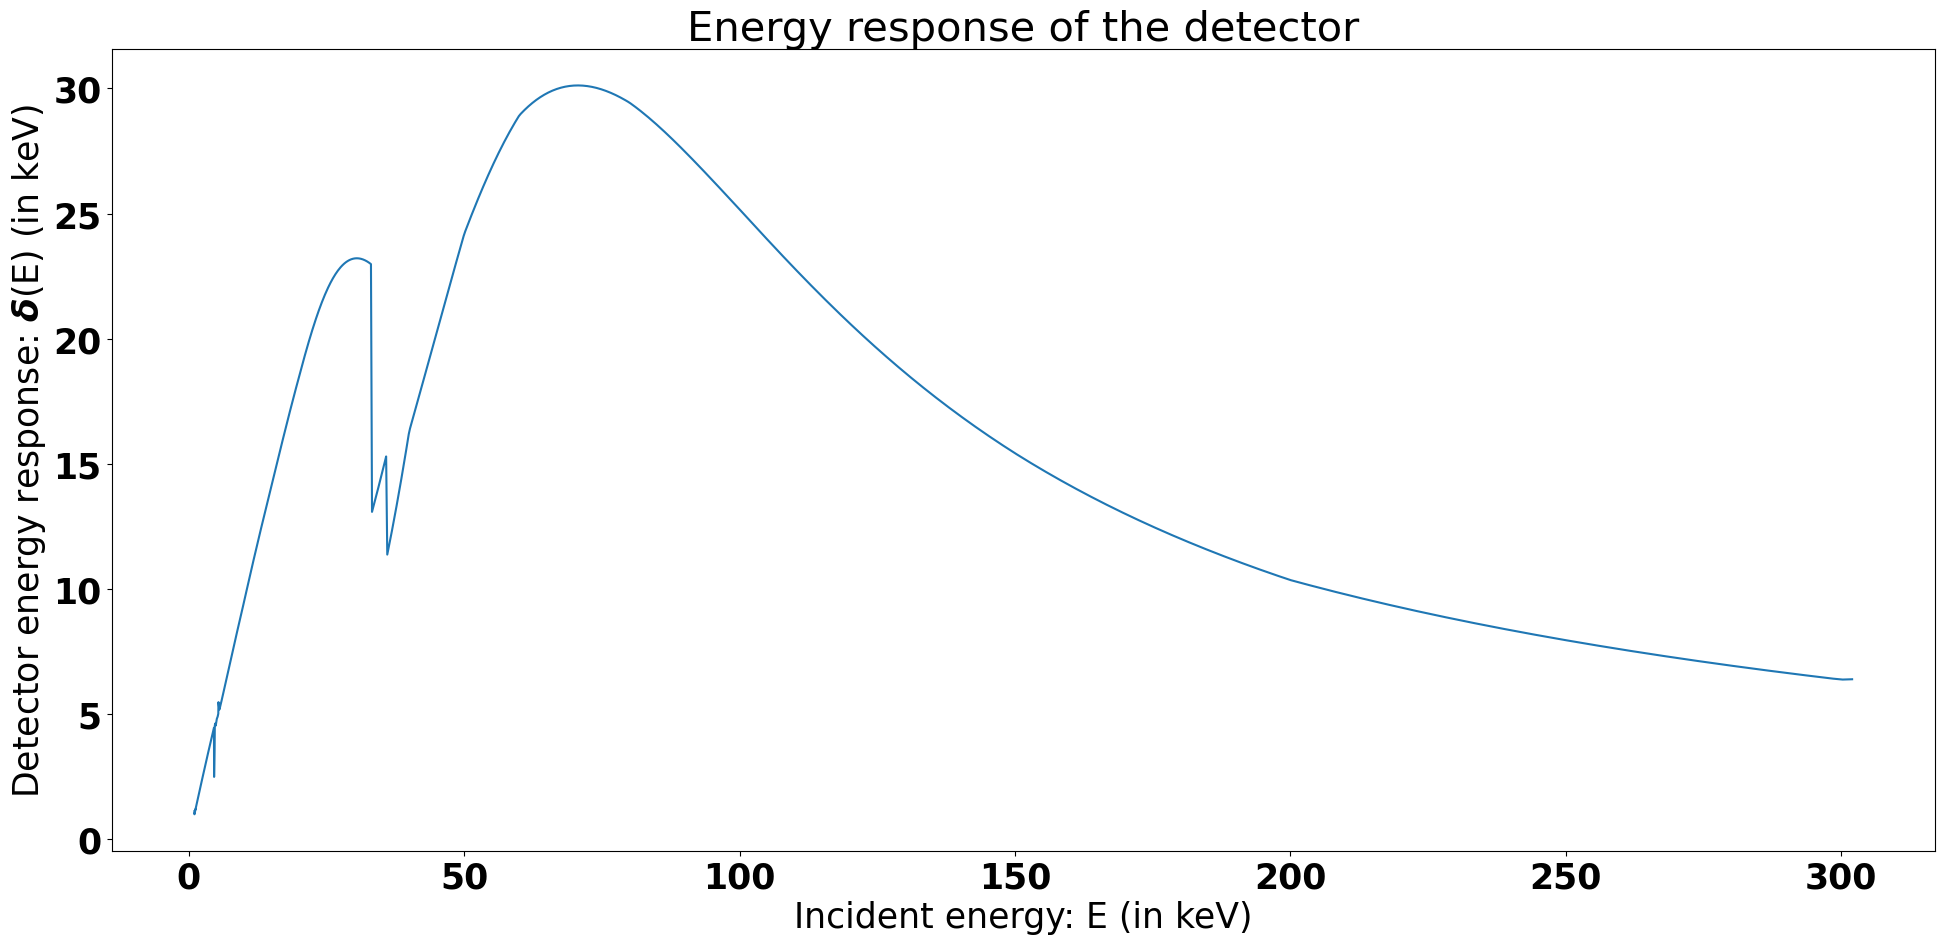

In [7]:
# Plot the energy response of the detector
detector_response = np.array(gvxr.getEnergyResponse("keV"))
plt.figure(figsize= (20,10))
plt.title("Energy response of the detector")
plt.plot(detector_response[:,0], detector_response[:,1])
plt.xlabel('Incident energy: E (in keV)')
plt.ylabel('Detector energy response: $\\delta$(E) (in keV)')
plt.tight_layout()
plt.savefig("../results/dragon/detector-energy_response.png", dpi=20)
plt.savefig("../results/dragon/detector-energy_response.pdf", dpi=600)

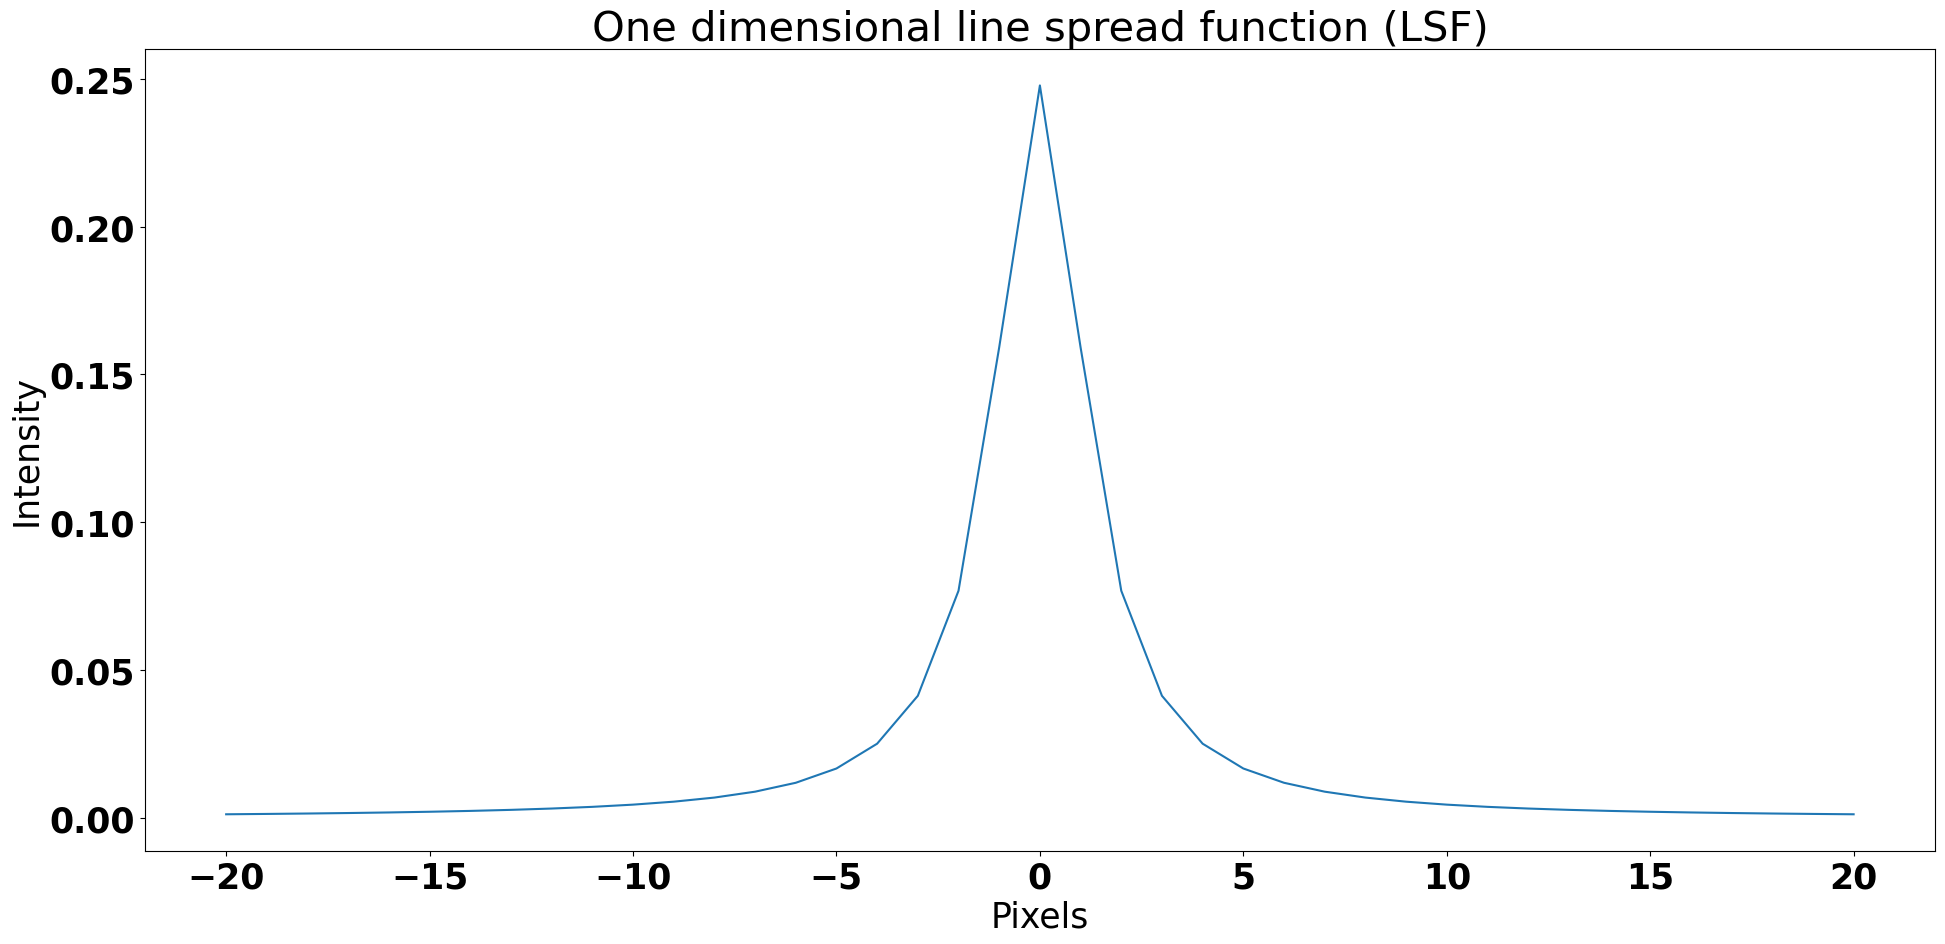

In [8]:
# Plot the energy response of the detector
lsf = np.array(gvxr.getLSF())
half_size = len(lsf) // 2
x = np.arange(-half_size, half_size + 1)

plt.figure(figsize= (20,10))
plt.title("One dimensional line spread function (LSF)")
plt.plot(x, lsf)
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.tight_layout()
plt.savefig("../results/dragon/detector-LSF.png", dpi=20)
plt.savefig("../results/dragon/detector-LSF.pdf", dpi=600)

In [9]:
# Create a source
print("Set up the beam")
gvxr.setSourcePosition(0.0,  -150.0, 0.0, "cm");
gvxr.usePointSource();
#  For a parallel source, use gvxr.useParallelBeam();

# Set its spectrum, here a monochromatic beam
# 1000 photons of 80 keV (i.e. 0.08 MeV) per ray
# gvxr.setMonoChromatic(0.08, "MeV", 1000);
# The following is equivalent: gvxr.setMonoChromatic(80, "keV", 1000);

# Or use a polychromatic beam
# The tube voltage is 160 keV
# The filtration is 1mm of tin (Sn)
# The anode angle is 12 degrees
# mAs is 0,5
# The source to detector distance in 50 cm
loadSpectrumSpekpy(160, filters=[["Sn", 1.0]], th_in_deg=12, mAs=0.5, z=150 - -40);

# Poisson noise will be enable
gvxr.enablePoissonNoise(); # Not needed as mAs was used in the function call above

Set up the beam
s = sp.Spek(kvp= 160 , th= 12 , mas= 0.5 , z= 190
31340330.86654578  photons / cm^2
78350.82716636446  photons / pixel


Fri Aug 16 12:12:25 2024 (WW) PythonLibs support was disabled when the library was compiled. This function setVoltage in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 12:12:25 2024 (WW) PythonLibs support was disabled when the library was compiled. This function setTubeAngle in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 12:12:25 2024 (WW) PythonLibs support was disabled when the library was compiled. This function setmAs in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 12:12:25 2024 (WW) PythonLibs support was disabled when the library was compiled. This function clearFiltration in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 12:12:25 2024 (WW) PythonLibs support was disabled when the library was compiled. This function addFilter in /io/gvxr/include/gVirtualXRay/XRayBeam.inl may have no visible effect.
Fri Aug 16 12:12:25 2024 ---- Initiali

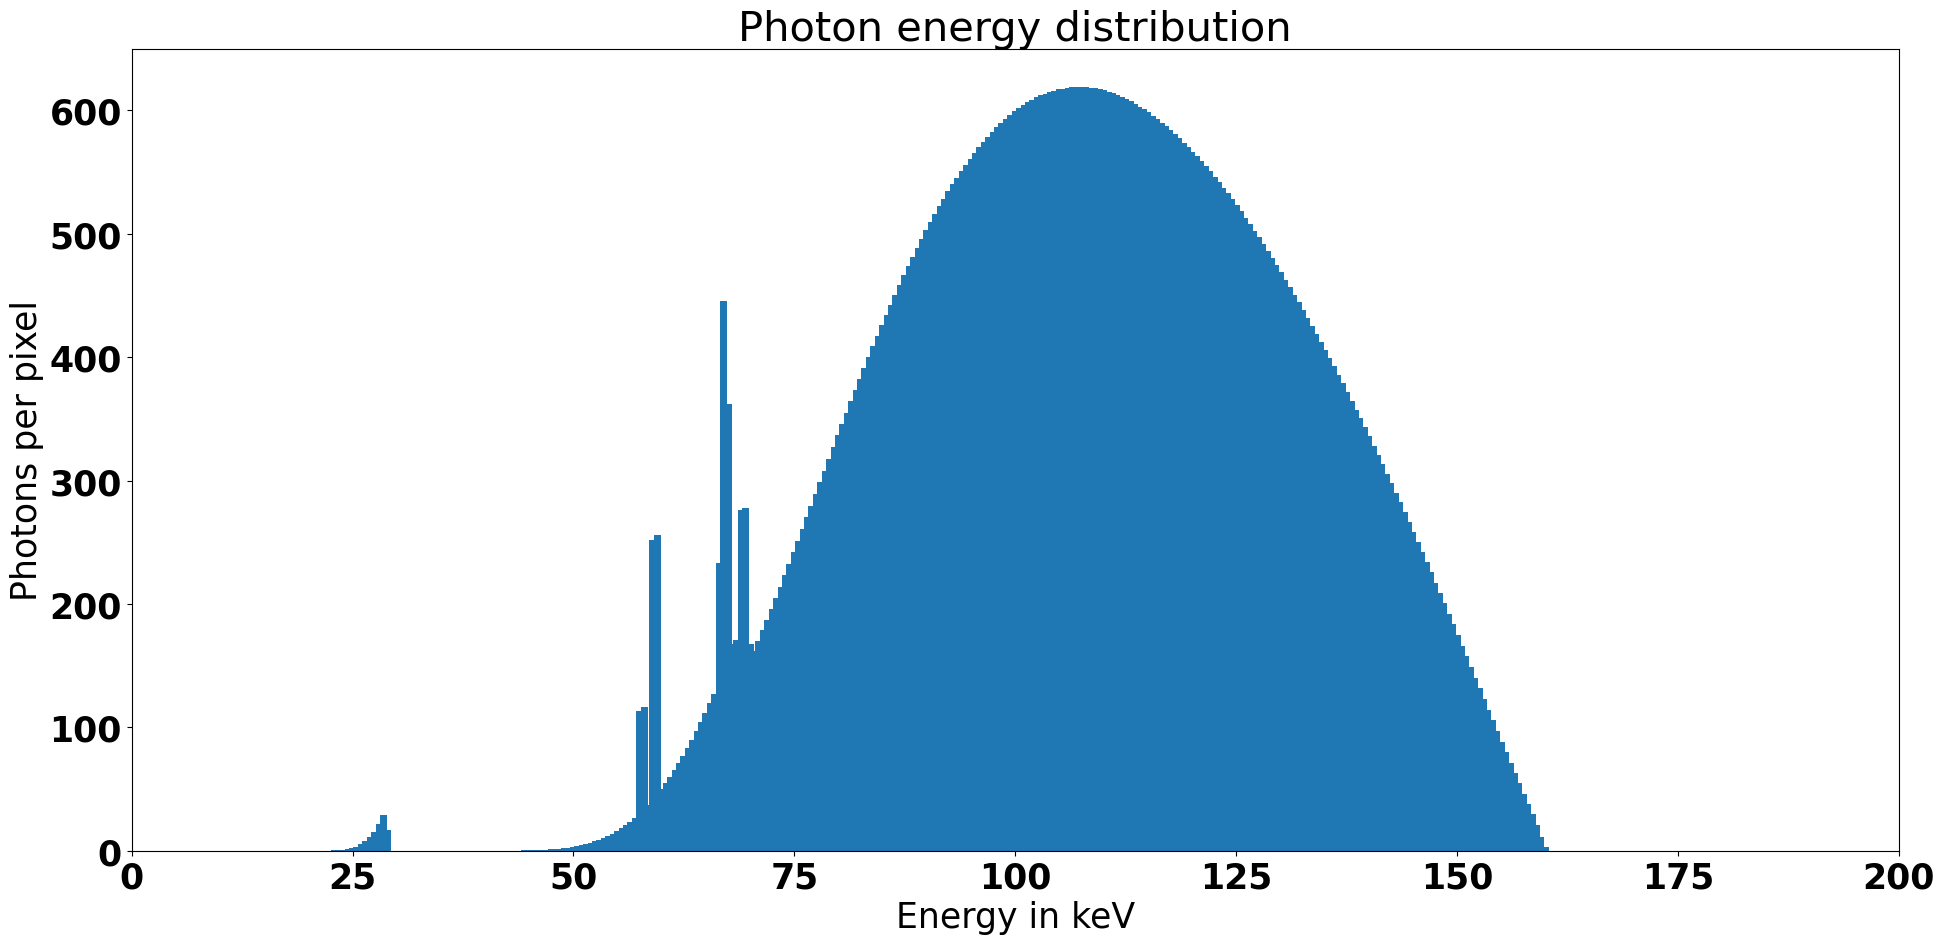

In [10]:
# Plot the beam spectrum
energy_bins = gvxr.getEnergyBins("keV")
photon_counts = gvxr.getPhotonCountEnergyBins()
plt.figure(figsize=(20,10))
plt.bar(energy_bins, photon_counts)
plt.xlabel('Energy in keV')
plt.ylabel('Photons per pixel')
plt.title('Photon energy distribution')
plt.xlim([0,200])
plt.tight_layout()

plt.savefig("../results/dragon/beam-spectrum.png", dpi=20)
plt.savefig("../results/dragon/beam-spectrum.pdf", dpi=600)

In [11]:
# Locate the sample STL file from the package directory
path = os.path.dirname(gvxr.__file__)
fname = os.path.join(path, "welsh-dragon-small.stl")

gvxr.loadMeshFile("Dragon", fname, "mm")
gvxr.moveToCentre("Dragon");

# Change the sample's colour
# By default the object is white, which is not always pretty. Let's change it to gold.
red = 255 / 255
green = 215 / 255
blue = 0 / 255
gvxr.setColour("Dragon", red, green, blue, 1.0)

# Material properties

# Iron (Z number: 26, symbol: Fe)
# gvxr.setElement("Dragon", 26)
# gvxr.setElement("Dragon", "Fe")

# Liquid water
# gvxr.setCompound("Dragon", "H2O")
# gvxr.setDensity("Dragon", 1.0, "g/cm3")
# gvxr.setDensity("Dragon", 1.0, "g.cm-3")

# Titanium Aluminum Vanadium Alloy
# gvxr.setMixture("Dragon", "Ti90Al6V4")
gvxr.setMixture("Dragon", [22, 13, 23], [0.9, 0.06, 0.04])
# gvxr.setMixture("Dragon", ["Ti", "Al", "V"], [0.9, 0.06, 0.04]) # Not yet implemented
# gvxr.setDensity("Dragon", 4.43, "g/cm3")
gvxr.setDensity("Dragon", 4.43, "g.cm-3")

Fri Aug 16 12:12:26 2024 ---- file_name:	/home/fpvidal/miniconda3/envs/gVXR-SPIE2024/lib/python3.10/site-packages/gvxrPython3/_gvxrPython3/welsh-dragon-small.stl	nb_faces:	457345	nb_vertices:	1372035	bounding_box (in cm):	(-4.47065, -74.9368, 23.5909)	(2.37482, -59.4256, 36.0343)


In [12]:
# Use k3d to perform the 3D visualisation
plot = visualise()
plot.display()

Output()

In [13]:
# Save the plot in an HTML file
if plot:
    with open('../results/dragon/snapshot.html','w') as fp:
        fp.write(plot.get_snapshot())

In [14]:
# Compute an X-ray image
x_ray_image = np.array(gvxr.computeXRayImage()).astype(np.single) / gvxr.getWhiteImage()

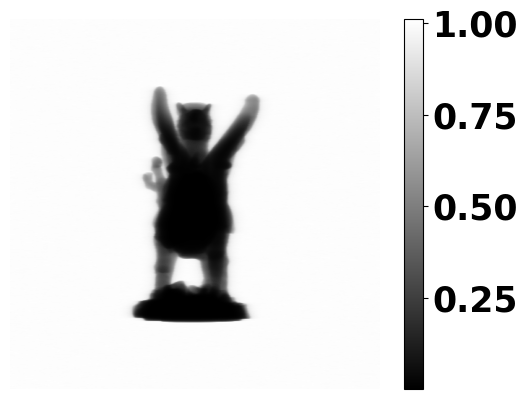

In [15]:
# Display the corresponding X-ray image
plt.imshow(x_ray_image, cmap="gray");
plt.colorbar()
plt.axis('off');

In [16]:
# Change to a white background (it could be useful for putting screenshots in papers)
gvxr.setWindowBackGroundColour(1.0, 1.0, 1.0, -1);

In [17]:
# Interactive visualisation
# The user can rotate the 3D scene and zoom-in and -out in the visualisation window.
# It can be useful to rotate the visualisation of the 3D environment and zoom in/out
# to take the best posible screenshots

# - Keys are:
#     - Q/Escape: to quit the event loop (does not close the window)
#     - B: display/hide the X-ray beam
#     - W: display the polygon meshes in solid or wireframe
#     - N: display the X-ray image in negative or positive
#     - H: display/hide the X-ray detector
# - Mouse interactions:
#     - Zoom in/out: mouse wheel
#     - Rotation: Right mouse button down + move cursor```
# gvxr.renderLoop()

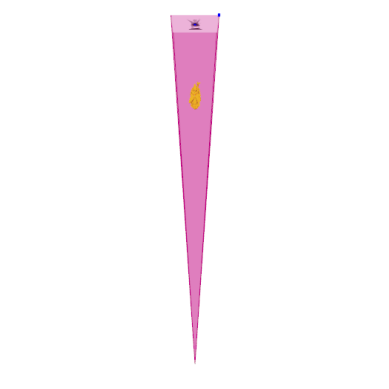

In [18]:
# Take and display a screenshot
gvxr.setZoom(2500);
gvxr.displayScene();
screenshot = gvxr.takeScreenshot();
plt.imshow(screenshot);
plt.axis('off');

## Simulate the CT acquisition and save the projections

In [19]:
start = time.time();

# Simulate a CT scan acquisition
gvxr.computeCTAcquisition("../results/dragon/projs", # Where to save the projections
                          "screenshots", # Where to save the screenshots
                          200, # Total number of projections
                          0, # First angle
                          True, # Include the last angle
                          360, # Last angle
                          60, # Number of flat images
                          0, 0, 0, "mm", # Centre of rotation
                          *gvxr.getDetectorUpVector()); # Rotation axis

stop = time.time();
runtime, unit = getRuntime(start, stop);
print("Execution time:", "{0:0.2f}".format(runtime), unit);

Execution time: 9.35 sec


In [20]:
# Save a JSON file
gvxr2json.saveJSON("../results/dragon.json");

mAs 0.5 kVp 160.0


## Set the CT reconstruction parameters

In [21]:
# Create the TIFF reader by passing the directory containing the files
reader = TIFFStackReader(file_name="../results/dragon/projs", dtype=np.float32)

# Read in file, and return a numpy array containing the data
data_original = reader.read()

# The data is stored as a stack of detector images, we use the CILlabels for the axes
axis_labels = ['angle','vertical','horizontal']

In [22]:
# Update the font size
font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

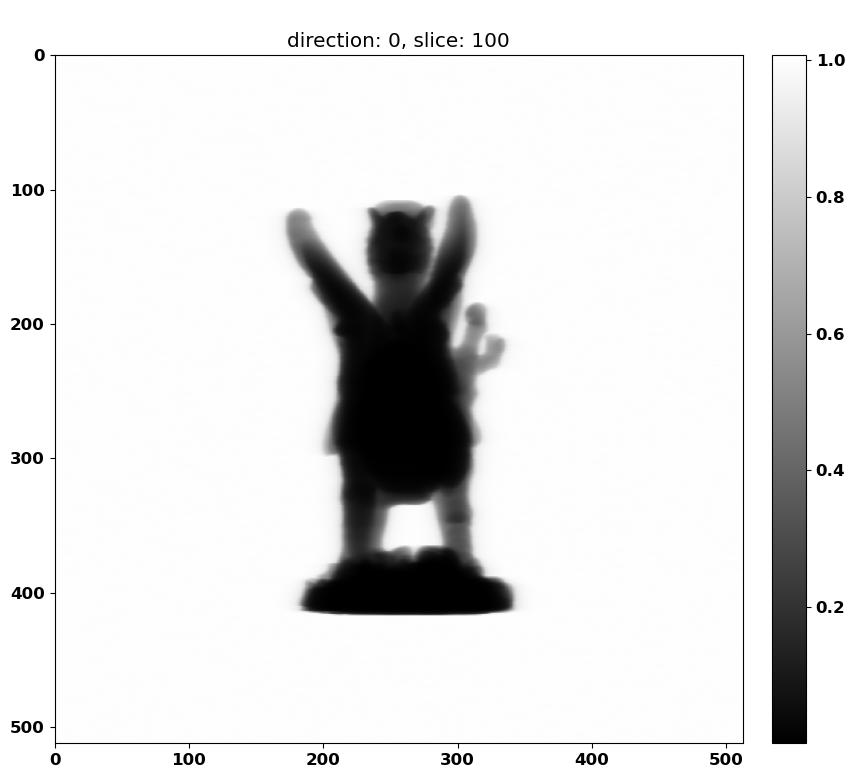

In [23]:
# Use show2D to visualise a projection
show2D(data_original, origin="upper-left")

In [24]:
# Interactive visualisation in Jupyter
islicer(data_original, origin="upper-left")

In [25]:
# Normalisation
# Not strictly needed as the data was already corrected
data_normalised = data_original / data_original.max()

# Prevent log of a negative value
data_normalised[data_normalised<1e-9] = 1e-9

# Linearisation
data_absorption = -np.log(data_normalised)

In [26]:
# Create the CIL geoemtry
geometry = AcquisitionGeometry.create_Cone3D(source_position=gvxr.getSourcePosition("cm"),
                                             detector_position=gvxr.getDetectorPosition("cm"),
                                             detector_direction_x=gvxr.getDetectorRightVector(),
                                             detector_direction_y=gvxr.getDetectorUpVector(),
                                             rotation_axis_position=gvxr.getCentreOfRotationPositionCT("cm"),
                                             rotation_axis_direction=gvxr.getRotationAxisCT())
                                         
# Set the angles, remembering to specify the units
geometry.set_angles(np.array(gvxr.getAngleSetCT()), angle_unit='degree')

# Set the detector shape and size
geometry.set_panel(gvxr.getDetectorNumberOfPixels(), gvxr.getDetectorPixelSpacing("cm"))

# Set the order of the data
geometry.set_labels(axis_labels)

# Set the angles, remembering to specify the units
geometry.set_angles(np.array(gvxr.getAngleSetCT()), angle_unit='degree')

# Set the detector shape and size
geometry.set_panel(gvxr.getDetectorNumberOfPixels(), gvxr.getDetectorPixelSpacing("cm"))

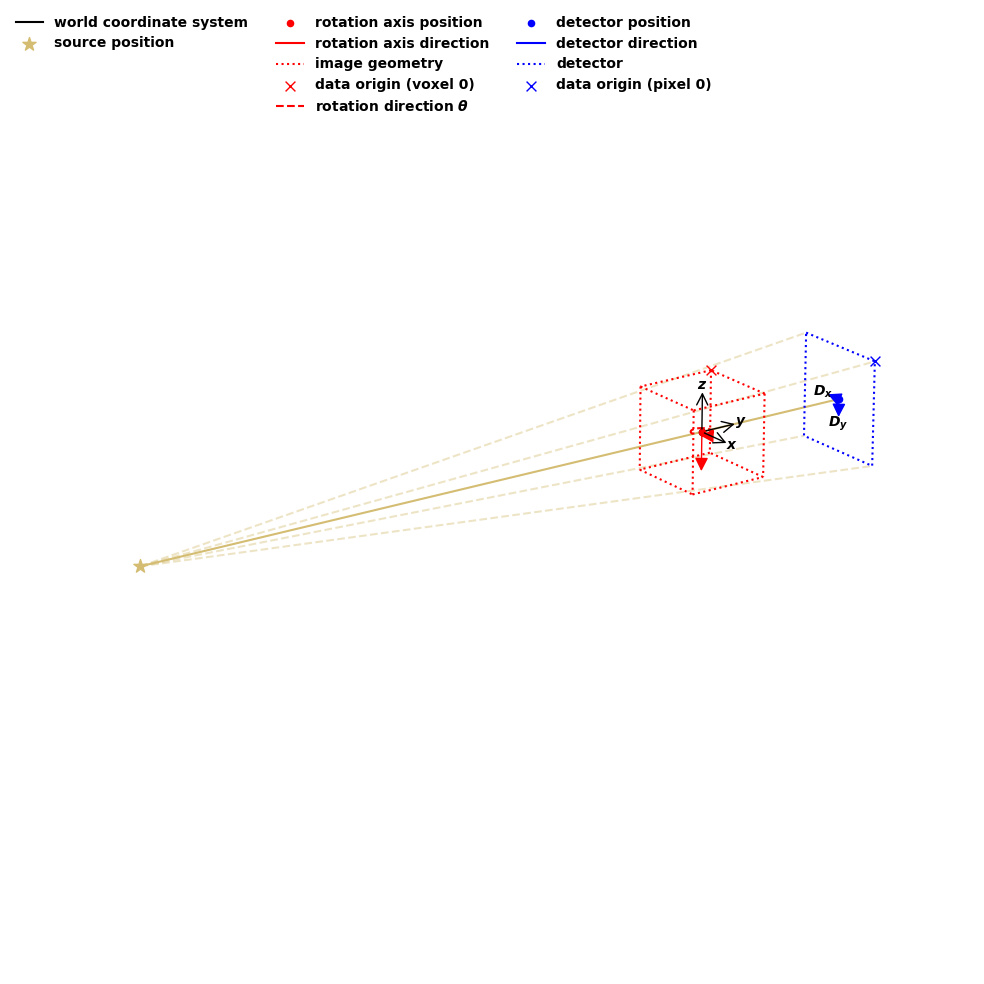

Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/geometry.png
Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/geometry.pdf


<Figure size 640x480 with 0 Axes>

In [27]:
# Display and save the geometry, does it look like a feasible CT scan set up?
fig = show_geometry(geometry);
fig.save("../results/dragon/geometry.png");
fig.save("../results/dragon/geometry.pdf");


In [28]:
# Print details of the scanning geometry
print(geometry)

3D Cone-beam tomography
System configuration:
	Source position: [   0., -150.,    0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [ 0.,  0., -1.]
	Detector position: [ 0., 40.,  0.]
	Detector direction x: [-1.,  0.,  0.]
	Detector direction y: [ 0.,  0., -1.]
Panel configuration:
	Number of pixels: [512 512]
	Pixel size: [0.05 0.05]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 200
	Angles 0-9 in degrees: [ 0.       ,  1.8      ,  3.6      ,  5.3999996,  7.2      ,  9.       ,
 10.799999 , 12.599999 , 14.4      , 16.199999 ]
	Angles 190-199 in degrees: [342.     , 343.8    , 345.59998, 347.4    , 349.19998, 351.     ,
 352.8    , 354.59998, 356.4    , 358.19998]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


In [29]:
# Prepare the data for the reconstruction
acquisition_data = AcquisitionData(data_absorption, deep_copy=False, geometry=geometry)
acquisition_data.reorder(order='tigre')
ig = acquisition_data.geometry.get_ImageGeometry()

In [30]:
# Print details of the reconstructed volume
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x512,y512,z512
voxel_size : x0.03947368421052632,y0.03947368421052632,z0.03947368421052632
center : x0,y0,z0



## Perform the CT reconstruction using the FDK algorithm and save the reconstructed volume

In [31]:
# Perform the FDK reconstruction
fdk =  FDK(acquisition_data, ig)
recon = fdk.run()

FDK recon

Input Data:
	angle: 200
	vertical: 512
	horizontal: 512

Reconstruction Volume:
	vertical: 512
	horizontal_y: 512
	horizontal_x: 512

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



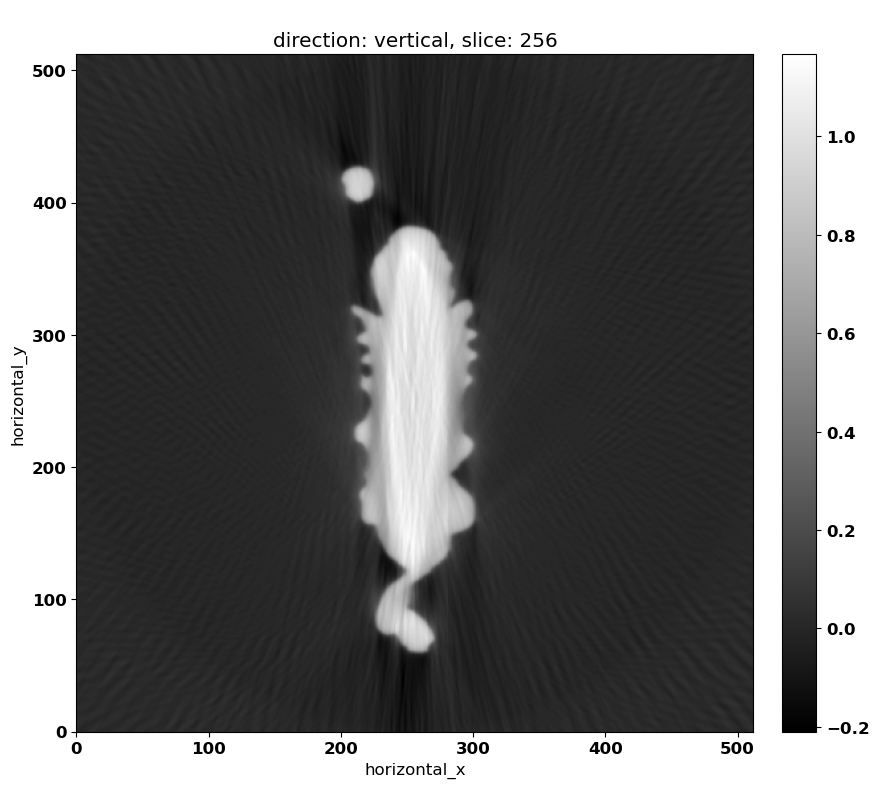

In [32]:
# Show a 2D slice
show2D(recon)

In [33]:
# Interactive visualisation in Jupyter
islicer(recon)

In [34]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon, file_name=os.path.join("../results/dragon/recons-FDK", "out")).write()

## Perform the CT reconstruction using the SIRT algorithm and save the reconstructed volume

In [35]:
# Create projection operator using Astra-Toolbox.
acquisition_data.reorder(order='astra')
A = ProjectionOperator(ig, geometry, "gpu")

In [36]:
# Create the initial guess
x0 = ig.allocate()

# non-zero constraint
constraint = IndicatorBox(lower=0)

# Instantiate the reconstruction algorithm
sirt = SIRT(initial=x0, operator=A, data=acquisition_data, constraint=constraint, max_iteration=500)

In [37]:
# Perform 500 iterations
sirt.update_objective_interval = 50
sirt.run(500)

recon_sirt_noisy = sirt.solution

  0%|          | 0/500 [00:00<?, ?it/s]

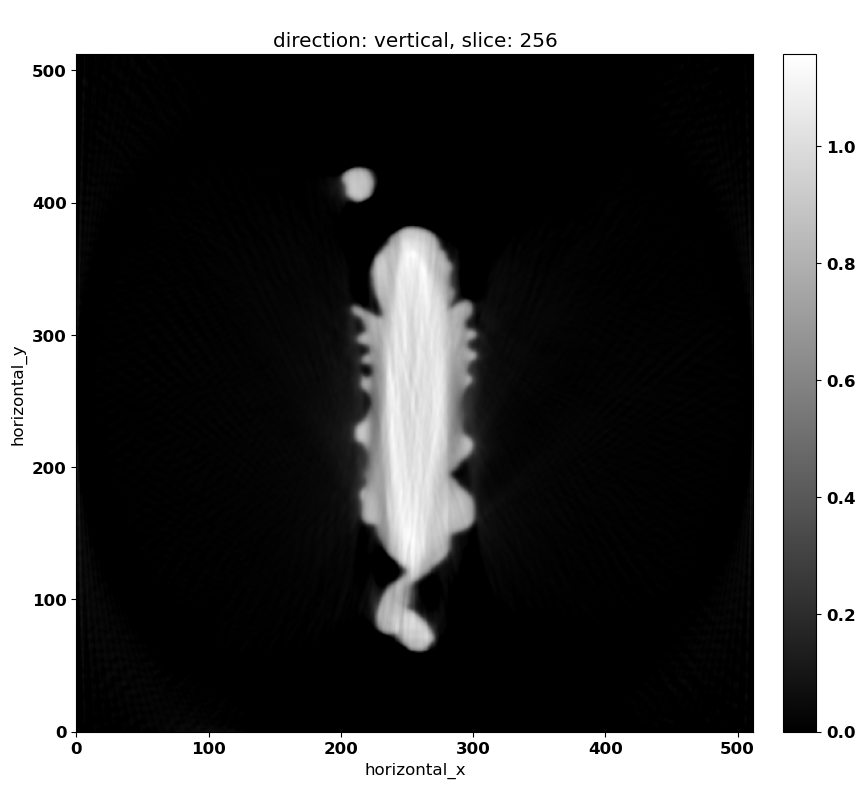

In [38]:
# Show a 2D slice
show2D(recon_sirt_noisy)

In [39]:
# Interactive visualisation in Jupyter
islicer(recon_sirt_noisy)

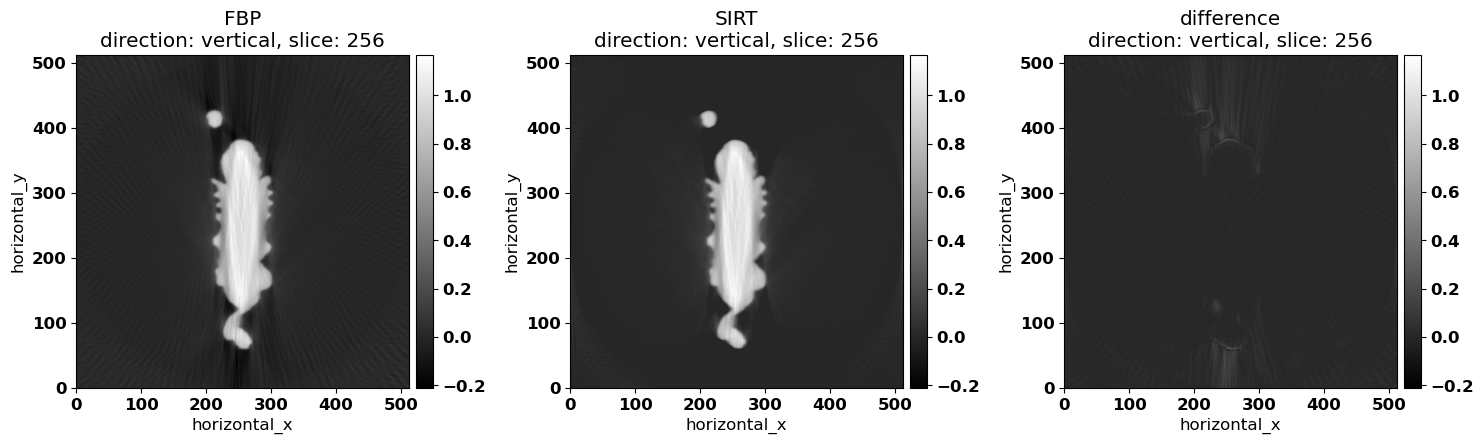

Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/comparison.png
Saved image as /home/fpvidal/PROGRAMMING/GitHub/gVXR-SPIE2024/results/dragon/comparison.pdf


<Figure size 640x480 with 0 Axes>

In [40]:
# Show a comparison
fig = show2D([recon, recon_sirt_noisy, (recon-recon_sirt_noisy).abs()], \
       ['FBP', 'SIRT', 'difference'], \
       cmap="gray", num_cols=3, size=(15,15), origin='bottom-left', fix_range=True);

fig.save("../results/dragon/comparison.png", dpi=300)
fig.save("../results/dragon/comparison.pdf", dpi=600)

In [41]:
# Save the CT volume as a TIFF stack
TIFFWriter(data=recon_sirt_noisy, file_name=os.path.join("../results/dragon/recons-SIRT", "out")).write()